# Merian project Part 2

**Explore the morphology of dwarf galaxies in H$\alpha$ using the Merian Survey data**

**Prerequisites**
- Need to install `reproject` and `photutils` and `cmasher`

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append(os.path.abspath('../../'))
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
from utils import pad_psf, show_image

# We can beautify our plots by changing the matpltlib setting a little
plt.rcParams['font.size'] = 18
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.linewidth'] = 2

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if not IN_COLAB:
    if not os.path.exists("../../../_static/ObsAstroData/"):
        os.makedirs("../../../_static/ObsAstroData/")
    # os.chdir('../../../_static/ObsAstroData/')
# os.chdir('./merian/')

# Part 3: Make your own H$\alpha$ map from HSC and Merian data

Again, some background knowledge goes here. What is HSC, what is image subtraction. What is tricky about it (e.g., PSF matching). 


In [3]:
merian = Table.read("../../../_static/ObsAstroData/merian/merian_dr1_specz_inband_lowmass_allbands.csv")
cutout_dir = "../../../_static/ObsAstroData/merian/cutouts/"

i = 1769
obj = merian[i]
coord = SkyCoord(obj['coord_ra_Merian'], obj['coord_dec_Merian'], unit='deg')
cname = obj['cname']

In [5]:
# np.where(merian['name'] == 'J100107.07+015416.20')

In [6]:
# Open images and psfs
cutouts = {band: fits.open(os.path.join(cutout_dir, "", f"{cname}_HSC-{band}.fits"))[1].data for band in ['g', 'r', 'i', 'z']}
cutouts['N708'] = fits.open(os.path.join(cutout_dir, "", f"{cname}_N708_merim.fits"))[1].data

cutout_headers = {band: fits.open(os.path.join(cutout_dir, "", f"{cname}_HSC-{band}.fits"))[1].header for band in ['g', 'r', 'i', 'z']}
cutout_headers['N708'] = fits.open(os.path.join(cutout_dir, "", f"{cname}_N708_merim.fits"))[1].header

psfs = {band: fits.open(os.path.join(cutout_dir, "", f"{cname}_HSC-{band}_psf.fits"))[0].data for band in ['g', 'r', 'i', 'z']}
psfs['N708'] = fits.open(os.path.join(cutout_dir, "", f"{cname}_N708_merpsf.fits"))[0].data

We need to pad the PSFs (we can also pad them in advance and provide students the ready version)

In [7]:
bands = list(cutouts.keys())

psf_shape = np.max(np.array([i.shape for i in psfs.values()]), 0)
cutout_shape = np.min(np.array([i.shape for i in cutouts.values()]), 0)

# make all the psfs the same shape
for i in psfs.keys():
    psfs[i] = pad_psf(psfs[i], psf_shape)

psf_shape, cutout_shape

(array([43, 43]), array([358, 358]))

## Part 3.1: measure PSF FWHM

Let's take a better look at the PSF of N708 band. Then we try to fit a Moffat model to the PSF, and calculate the FWHM of the PSF.

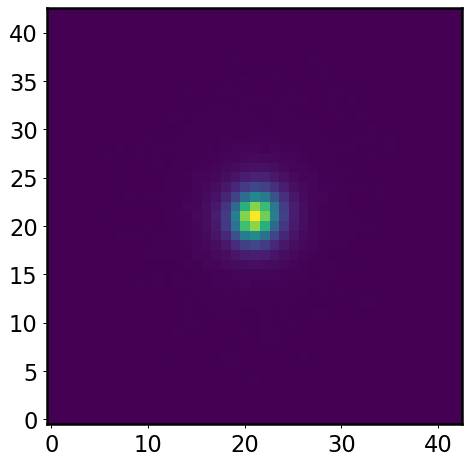

In [7]:
band = 'i'
psf = psfs[band]
plt.imshow(psf)

In [8]:
from astropy.modeling import models, fitting
y, x = np.mgrid[:psf.shape[0], :psf.shape[1]]
model = models.Moffat2D(x_0=psf.shape[1]/2, y_0=psf.shape[0]/2, amplitude=np.max(psf))
fitter = fitting.LevMarLSQFitter()
best_fit = fitter(model, x, y, psf)
print(f'FWHM = {best_fit.fwhm:.3f} pix')

FWHM = 3.630 pix


<Axes: title={'center': 'residual'}>

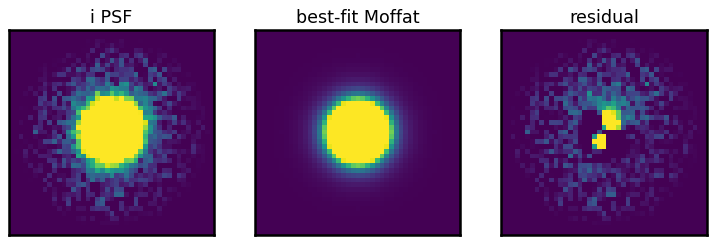

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

show_image(psf, ax=axes[0], fig=fig, vmin=0, vmax=np.percentile(psf, 92), title=f'{band} PSF')
show_image(best_fit(x, y), ax=axes[1], fig=fig, vmin=0, vmax=np.percentile(psf, 92), title='best-fit Moffat')
show_image(psf - best_fit(x, y), ax=axes[2], fig=fig, vmin=0, vmax=np.percentile(psf, 92), title='residual')

Then we can summarize the above procedure as the `calc_PSF_FWHM` function:

```python
def calc_PSF_FWHM(psfs=None):
    """
    Measure the FWHM of the PSF by fitting a 2D Moffat profile to each PSF cutout.
    
    Parameters
    ----------
    psfs: dict
        A dictionary containing the PSF images for each band.
    
    Returns
    -------
    fwhm: dict
        A dictionary containing the FWHM of the PSF for each band (in pixels).
    """
    from astropy.modeling import models, fitting
    bands = list(psfs.keys())

    fit_p = fitting.LevMarLSQFitter()
    fwhms = {}
    for ix, band in enumerate(bands):
        z = psfs[band]
        mid = np.array(z.shape) // 2
        y, x = np.mgrid[: z.shape[0], : z.shape[1]]
        p_init = models.Moffat2D(x_0=mid[0], y_0=mid[1], amplitude=z[mid[0], mid[1]])
        p = fit_p(p_init, x, y, z)
        fwhms[band] = p.fwhm

    return fwhms

```

## Part 3.2: make H$\alpha$ map for Merian dwarfs

In [10]:
from utils import calc_PSF_FWHM
fwhms = calc_PSF_FWHM(psfs)
print(fwhms)
worst_psf = max(fwhms.keys(), key=fwhms.get)
print(f"Worst psf is in band {worst_psf}")

{'g': 4.203394706999026, 'r': 3.7680022257238175, 'i': 3.630464252023418, 'z': 4.033193740608883, 'N708': 4.849972192692815}
Worst psf is in band N708


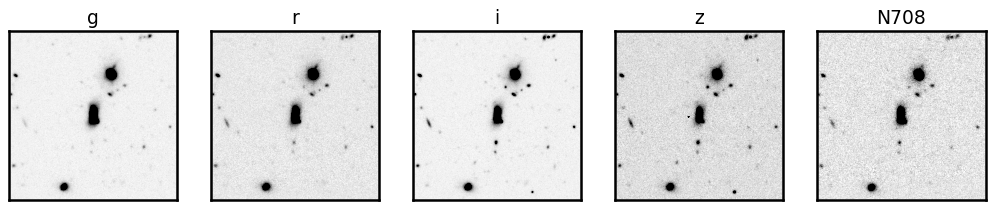

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(14, 3))
for i, band in enumerate(cutouts.keys()):
    show_image(cutouts[band], fig=fig, ax=axes[i], cmap='Greys')
    axes[i].set_title(band, fontsize=15)

### (Vanilla) Image subtraction: $N708 - z$

In [12]:
from astropy.wcs import WCS
from reproject import reproject_interp
from astropy.nddata import Cutout2D
import astropy.units as u
import cmasher as cmr

In [13]:
# reproject images to line up properly
size = 60 * u.arcsec
wcs_z = WCS(cutout_headers["z"])
cutouts_reproj = {}
for i in cutouts.keys():
    wcs_i = WCS(cutout_headers[i])
    stamp_i = Cutout2D(cutouts[i], coord, size, wcs=wcs_i)
    cutouts_reproj[i], _ = reproject_interp((stamp_i.data, stamp_i.wcs), wcs_z)

Text(0.5, 1.1, 'Direct subtraction: PSFs do not match')

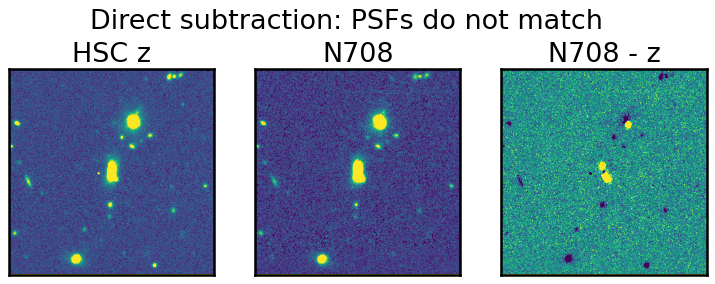

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
show_image(cutouts_reproj['z'], fig=fig, ax=axes[0], show_colorbar=False)
axes[0].set_title('HSC z')

show_image(cutouts_reproj['N708'], fig=fig, ax=axes[1], show_colorbar=False)
axes[1].set_title('N708')

show_image(cutouts_reproj['N708'] - cutouts_reproj['z'], 
           fig=fig, ax=axes[2], show_colorbar=False)
axes[2].set_title('N708 - z')

plt.suptitle('Direct subtraction: PSFs do not match', y=1.1)

###  Better Image subtraction: match PSFs!

In [15]:
from photutils.psf import matching
from astropy.convolution import convolve_fft
from utils import get_central_region
from astropy.visualization import ImageNormalize, LuptonAsinhStretch, make_lupton_rgb

In [16]:
cutouts_matched = {}
window = matching.CosineBellWindow(alpha=0.8)
for band in bands:
    kernel = matching.create_matching_kernel(psfs[band], psfs[worst_psf], window=window)
    cutouts_matched[band] = convolve_fft(cutouts[band], kernel)
    if (band == worst_psf):
        cutouts_matched[band] = cutouts[band] # no need to touch the worst band
        continue

In [17]:
# reproject images to line up properly
size = 60 * u.arcsec
wcs_z = WCS(cutout_headers["z"])
cutouts_matched_reproj = {}
for band in bands:
    wcs_i = WCS(cutout_headers[band])
    stamp_i = Cutout2D(cutouts_matched[band], coord, size, wcs=wcs_i)
    cutouts_matched_reproj[band], _ = reproject_interp(
        (stamp_i.data, stamp_i.wcs), wcs_z
    )

Text(0.5, 1.1, 'Subtraction after PSF matching')

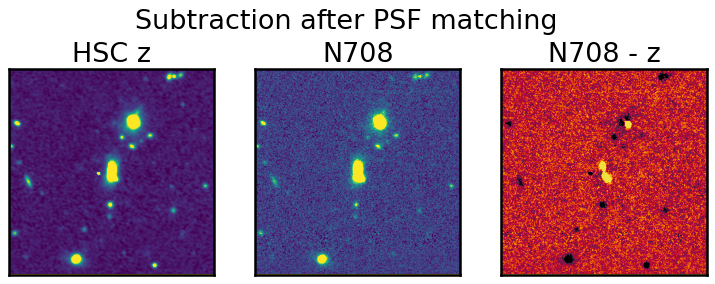

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
show_image(cutouts_matched_reproj['z'], fig=fig, ax=axes[0], show_colorbar=False)
axes[0].set_title('HSC z')

show_image(cutouts_matched_reproj['N708'], fig=fig, ax=axes[1], show_colorbar=False)
axes[1].set_title('N708')

show_image(cutouts_matched_reproj['N708'] - cutouts_matched_reproj['z'], 
           fig=fig, ax=axes[2], show_colorbar=False, cmap="cmr.ember", percl=99.6)
axes[2].set_title('N708 - z')

plt.suptitle('Subtraction after PSF matching', y=1.1)

In [21]:
cutouts_matched_reproj['ha'] = cutouts_matched_reproj['N708'] - 1 * cutouts_matched_reproj['z']

<Axes: >

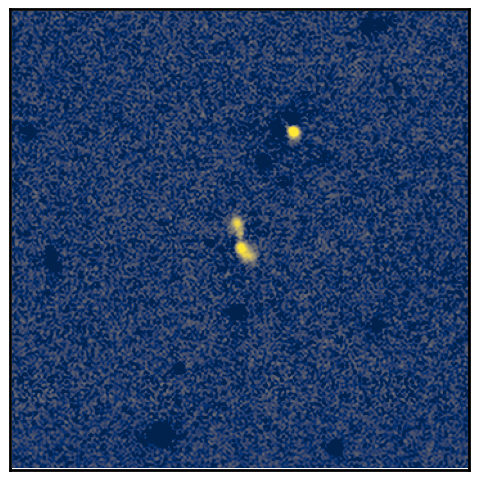

In [22]:
norm = ImageNormalize(cutouts_matched_reproj['ha'], vmin=-0.1, vmax=np.nanpercentile(cutouts_matched_reproj['ha'], 99.8),
                      stretch=LuptonAsinhStretch(stretch=0.8, Q=3))
show_image(cutouts_matched_reproj['ha'], norm=norm, cmap='cividis', figsize=(6,6))

### Make pretty image with H$\alpha$ map highlighted

In [23]:
cuts = get_central_region(cutouts_matched_reproj, 220)

Text(0.5, 1.0, 'grz+H$\\alpha$ (blue)')

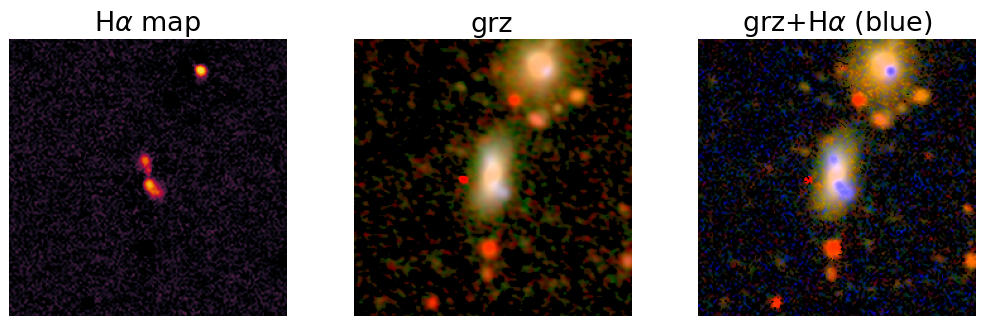

In [24]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 4))

norm = ImageNormalize(cuts['ha'], vmin=-0.1, vmax=np.nanpercentile(cuts['ha'], 99.8),
                      stretch=LuptonAsinhStretch(stretch=0.8, Q=3))
ax1.imshow(cuts['ha'], norm=norm, cmap='cmr.ember', origin='lower')
ax1.axis('off')
ax1.set_title(r'H$\alpha$ map')

rgb = make_lupton_rgb(cuts['z'], #red
                      cuts['r'], #green
                      cuts['g'], # + 1.0 * cuts['ha'], #blue
                      stretch=0.3, Q=6, minimum=[-0.02, -0.02, 0.06])
ax2.imshow(rgb, origin='lower')
ax2.axis('off')
ax2.set_title('grz')

rgb = make_lupton_rgb(cuts['z'], #red
                      cuts['r'], #green
                      1.1 * cuts['g'] + 1.0 * cuts['ha'], #blue
                      stretch=0.3, Q=6, minimum=[-0.02, -0.02, 0.06])
ax3.imshow(rgb, origin='lower')
ax3.axis('off')
ax3.set_title(r'grz+H$\alpha$ (blue)')

/Users/jiaxuanl/Softwares/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/visualization/basic_rgb.py:153: RuntimeWarning: invalid value encountered in cast
  return image_rgb.astype(output_dtype)


Text(0.5, 1.0, 'grz+H$\\alpha$ (blue)')

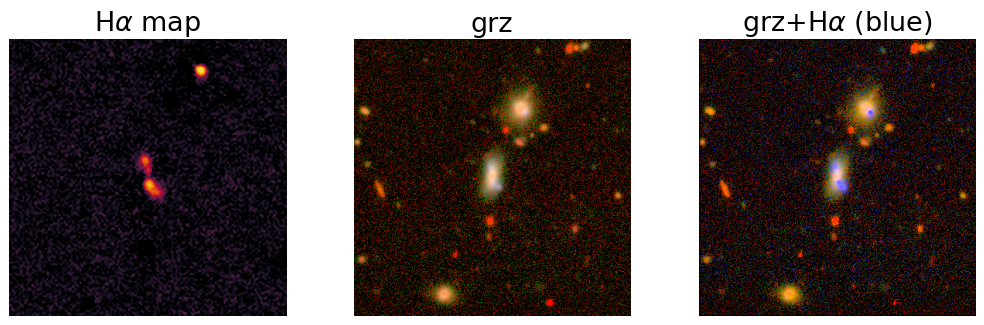

In [25]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 4))

norm = ImageNormalize(cuts['ha'], vmin=-0.1, vmax=np.nanpercentile(cuts['ha'], 99.8),
                      stretch=LuptonAsinhStretch(stretch=0.8, Q=3))
ax1.imshow(cuts['ha'], norm=norm, cmap='cmr.ember', origin='lower')
ax1.axis('off')
ax1.set_title(r'H$\alpha$ map')

rgb = make_lupton_rgb(cutouts['z'], #red
                      cutouts['r'], #green
                      cutouts['g'], #blue
                      stretch=0.5, Q=6, minimum=[-0.02, -0.02, 0.06])
ax2.imshow(rgb, origin='lower')
ax2.axis('off')
ax2.set_title('grz')

rgb = make_lupton_rgb(cutouts_reproj['z'], #red
                      cutouts_reproj['r'], #green
                      1.1 * cutouts_reproj['g'] + 1.2 * cutouts_matched_reproj['ha'], #blue
                      stretch=0.5, Q=6, minimum=[-0.02, -0.02, 0.06])
ax3.imshow(rgb, origin='lower')
ax3.axis('off')
ax3.set_title(r'grz+H$\alpha$ (blue)')